In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
import pandas as pd
import numpy as np

In [5]:
path = Path('../data/train')

In [6]:
path.ls()

(#3) [Path('../data/train/healthy_wheat'),Path('../data/train/leaf_rust'),Path('../data/train/stem_rust')]

In [7]:
def get_y(r): return parent_label(r).split(" ")

In [8]:
parent_label??

Signature: parent_label(o)
Source:   
def parent_label(o):
    "Label `item` with the parent folder name."
    return Path(o).parent.name
File:      c:\users\marianne\anaconda3\envs\fastai\lib\site-packages\fastai\data\transforms.py
Type:      function


In [9]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter=RandomSplitter(seed=42),
                    get_items=get_image_files,
                    get_y=get_y,
                    item_tfms=Resize(460),
                    batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = dblock.dataloaders(path, num_workers=0)

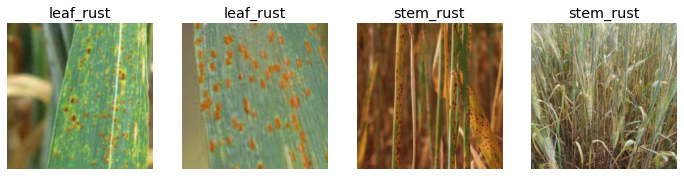

In [10]:
dls.show_batch(max_n=4, nrows=1)

In [11]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2)).to_fp16()

In [12]:
#learn.lr_find()

In [13]:
learn.fine_tune(3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.530881,0.494638,0.700952,01:23
1,0.474671,0.425896,0.754286,01:23
2,0.422470,0.386223,0.758095,01:23


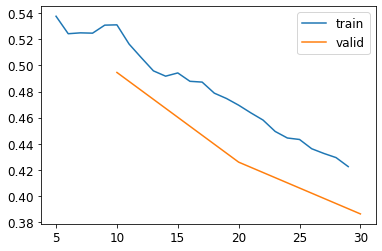

In [15]:
learn.loss_func

In [14]:
learn.recorder.plot_loss()

FlattenedLoss of BCEWithLogitsLoss()

In [16]:
x,y = dls.one_batch()

In [17]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

In [18]:
preds[0].sum()

tensor(1.0886)

In [19]:
learn.model(x).shape

torch.Size([64, 3])

In [20]:
learn.export()

In [21]:
learn.dls.vocab

['healthy_wheat', 'leaf_rust', 'stem_rust']